### Importamos librerias necesarias.

In [1]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, precision_score, r2_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

## Eliminamos warnings de sklearn
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore'
                        , category = ConvergenceWarning
                        , module = 'sklearn')

### Funciones:
* Crear gráficos para analizar el peso en churn de cada variable.
* Pasar a porcentajes la matriz de confusión.

In [2]:
def plot(df, col, Var = 'Churn'):
    df_temp = df.groupby([col], as_index = True).mean()[Var].sort_values(ascending = True)
    
    Grafico = df_temp.plot(kind = 'barh'
                       , width = 0.5
                       , color = plt.get_cmap('Blues')(np.linspace(start = 0.15
                                           , stop = 0.85
                                           , num = len(df_temp)))
                       , stacked = True
                       , legend = False
                       , fontsize = 10)
    
    Grafico.set_xlim([0,0.55])
    Grafico.set_ylabel('')
    Grafico.grid(axis='x',alpha=0.25)
    Grafico.set_xticklabels(['{:3.0f} %'.format(x * 100) for x in Grafico.get_xticks()])
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['left'].set_visible(True)

    plt.tick_params(left = False, bottom = False)
    plt.title(col)
    df_temp = None
    
def matriz(y, pred, Modelo = ''):
    mc = confusion_matrix(y, pred)
    Total = sum(np.transpose(mc))
    mcr = np.transpose(np.round(np.transpose(mc) / Total * 100,2))
    MC = pd.DataFrame(mc, columns=['No', 'Si'])

    MC['index'] = ['No', 'Si']
    MC['No'] *= -1

    Grafico = MC.set_index('index').sort_values(['index']
                                                , ascending=False).plot(kind = 'barh'
                                                                        , stacked = True
                                                                        , width = 0.75
                                                                        , color=[['#c9c9c9','#e60000'],['#00c800','#c9c9c9']]
                                                                        , legend = False
                                                                        , figsize = (3,1.2))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.gca().grid(axis='x',alpha=0)
    plt.gca().grid(axis='y',alpha=0)
    plt.gca().set_xlabel('{:.2f} % - '.format(np.mean(y == pred) * 100) + Modelo
                         , fontsize = 12
                         , alpha = 0.6)
    plt.gca().set_ylabel('')
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    
    plt.show()
    plt.close()

In [3]:
def markdown(txt):
    display(Markdown(txt))

### Cargamos datos y eliminamos valores faltantes en _TotalCharges_.
* Creamos Churn_b con valores binarios.
* Mezclamos el DataFrame para hacer los análisis.

In [4]:
le = LabelEncoder() 

df = pd.read_csv('data.csv')

df['TotalCharges'].replace(' ', np.nan, inplace=True)
df = df.dropna(subset = ['TotalCharges'])
df = df.sample(frac = 1
               , random_state = 12345)
   
df['Churn'] =  df[['Churn']].apply(le.fit_transform)

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3281,6322-PJJDJ,Male,0,Yes,No,49,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Electronic check,94.80,4690.65,0
1625,1262-OPMFY,Female,0,Yes,No,9,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.75,655.9,1
4606,1734-ZMNTZ,Female,0,Yes,Yes,11,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.00,300.7,0


In [5]:
df_Churn = df.groupby(by = ['Churn'])['customerID'].count().reset_index()
df_Churn['Ratio'] = df_Churn.customerID / df_Churn.customerID.sum()
df_Churn

,Churn,customerID,Ratio
0,0,5163,0.734215
1,1,1869,0.265785


### Creamos lista de columnas y eliminamos las que contienen datos numéricos.
* Creamos lista de las variables a analizar impacto en Churn.
* Creamos gráfico para ver impacto.

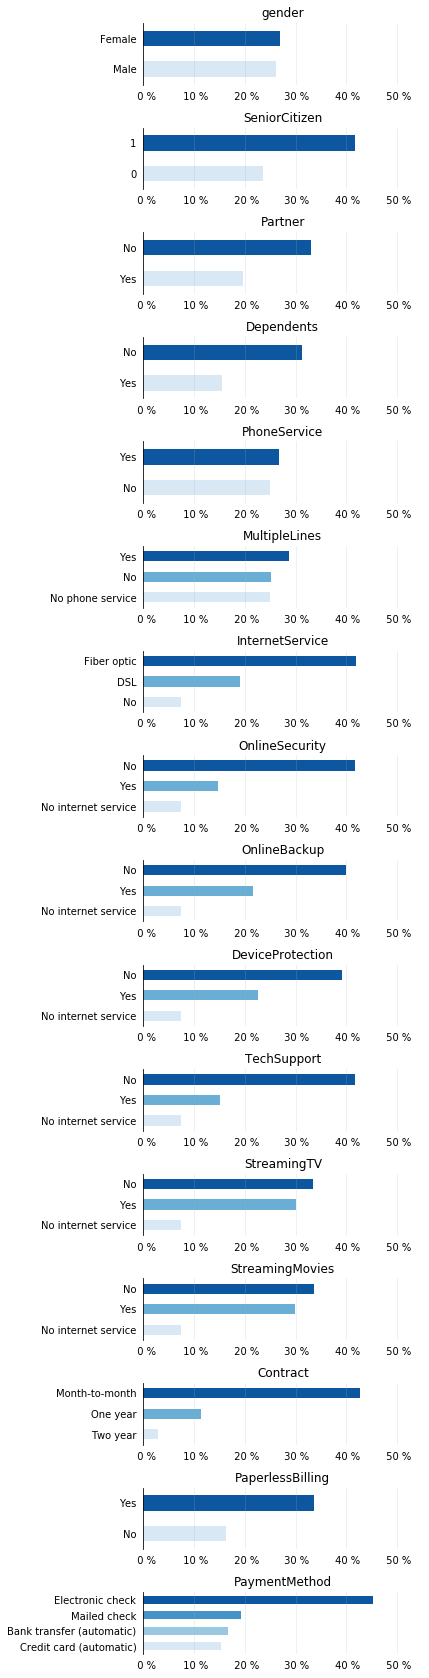

In [6]:
columnsList = df.columns.tolist()
excluir = ['customerID','TotalCharges','tenure','MonthlyCharges','Churn','Churn_b']

for i in excluir:
    if i in columnsList:
        columnsList.remove(i)

fig = plt.figure(figsize =(5, 30)) 
fig.patch.set_facecolor('white')

plt.subplots_adjust(hspace = .7)

for i in range(1,len(columnsList) + 1):    
    plt.subplot(len(columnsList), 1, i)
    plot(df, columnsList[i -1])

plt.show()
plt.close()

### Análisis de variables numéricas

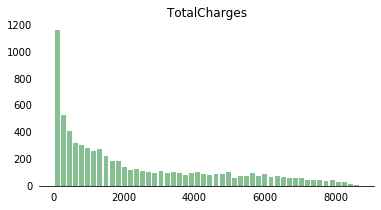

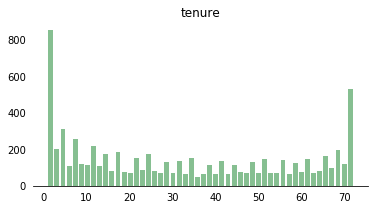

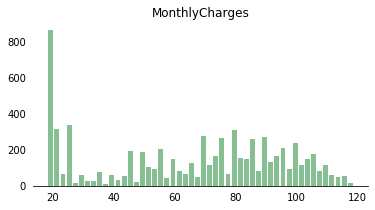

In [7]:
Var_Continuas = ['TotalCharges','tenure','MonthlyCharges']

for i in Var_Continuas:
    df[[i]].apply(pd.to_numeric).hist(bins = 50
                                      , grid = False
                                      , color = '#86bf91'
                                      , zorder = 2
                                      , figsize = (6, 3)
                                      , rwidth = 0.8)
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    plt.gca().spines['bottom'].set_visible(True)
    plt.tick_params(left = False, bottom = False)
    plt.show()
    plt.close()

### Creamos arbol de decisión de la variable Tenure

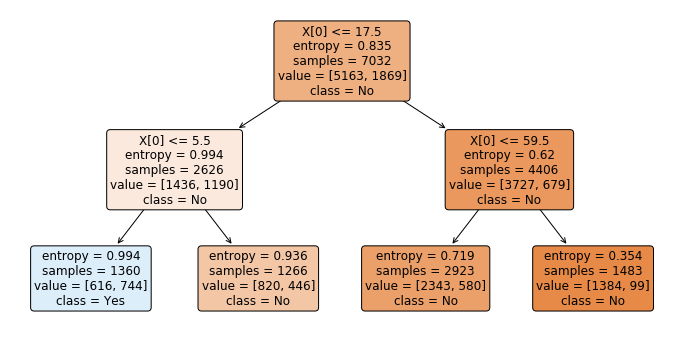

In [8]:
X = df[['tenure']]
y = df['Churn'] 

tree = DecisionTreeClassifier(criterion = 'entropy'
                                 , min_samples_split = 2000
                                 , max_depth = 2 )

tree = tree.fit(X, y)

plt.rcParams['figure.figsize'] = (12, 6)
Grafico = plot_tree(tree
                    , fontsize = 12
                    , max_depth = 7
                    , impurity = True
                    , rounded = True
                    , filled= True
                    , class_names = ['No', 'Yes'] )

plt.savefig('tree.png', dpi = 210)
plt.show()
plt.close()

puntos de corte 17.5 y 59.5

In [9]:
df['Tenure'] = df.tenure.map(lambda x: 'bajo' if x <= 17.5 else ('medio' if x <= 59.5 else 'alto'))
columnsList.append('Tenure')

df.groupby(['Tenure'])['Churn'].count().reset_index()

,Tenure,Churn
0,alto,1483
1,bajo,2626
2,medio,2923


In [10]:
X = df[columnsList]
y = df['Churn']

XE, XT, ye, yt = train_test_split(X
                                  , y
                                  , test_size = 0.25
                                  , random_state = 0)

In [11]:
Params = {'Random Forest': RandomForestClassifier(n_estimators = 250
                                                   , random_state = 0)
           , 'SGD': SGDClassifier(max_iter = 5
                                  , tol = None)
           , 'Perceptron': MLPClassifier(random_state = 0)
           , 'KNN': KNeighborsClassifier()
           , 'Tree Classifier': DecisionTreeClassifier(criterion = 'entropy'
                                                       , random_state = 0)
           , 'Estra Tree Classifier': ExtraTreesClassifier(random_state = 0)
           , 'Gradient Boosting Classifier': GradientBoostingClassifier(random_state = 0)
           , 'SVC': SVC(kernel = 'linear'
                        , random_state = 0
                        , gamma = 'scale' )
           , 'Regresión logística': LogisticRegression(solver = 'lbfgs'
                                                       , multi_class = 'multinomial'
                                                       , class_weight = 'balanced'
                                                       , random_state = 0)}

Nums = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'median')), 
        ('scaler' , StandardScaler())])

Text = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
        ('onehot' , OneHotEncoder(handle_unknown = 'ignore'))])

Pipe = ColumnTransformer(
    transformers = [
        ('num', Nums, X.select_dtypes(include = ['int64', 'float64']).columns), 
        ('cat', Text, X.select_dtypes(include = ['object']).columns)])

### Comparativa de los distintos modelos:

* Matríz de confusión:

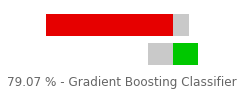

* Precisión modelos sobre base test:

0.7906712172923777


,Modelo,Precisión (accuracy),Cross Val,Score (True),R Cuadrado,Recall
0,Gradient Boosting Classifier,79.07,0.800339,61.73,-0.0912164,"[0.89, 0.5]"
1,SVC,77.65,0.78972,58.96,-0.165348,"[0.89, 0.45]"
2,Random Forest,77.42,0.769055,57.59,-0.177209,"[0.88, 0.48]"
3,Perceptron,77.02,0.778914,56,-0.197966,"[0.86, 0.52]"
4,Estra Tree Classifier,76.34,0.765074,55.15,-0.233549,"[0.87, 0.46]"
5,KNN,75.09,0.757483,51.86,-0.298785,"[0.83, 0.52]"
6,Regresión logística,73.72,0.748775,49.51,-0.369951,"[0.72, 0.78]"
7,Tree Classifier,72.7,0.733028,47.13,-0.423326,"[0.82, 0.45]"
8,SGD,65.98,0.7539,41.48,-0.773227,"[0.62, 0.76]"


In [12]:
Result, classifiersList = [{},[]]

kf = KFold(n_splits = 10)
           
markdown(f'### Comparativa de los distintos modelos:') 
           
for i in Params:
    Score, lista = [[],[]]
    clf = Pipeline(steps=[('Prepo', Pipe), 
                          ('Modelo', Params[i])])
    clf.fit(XE, ye)
    Score.append(round(np.mean(yt == clf.predict(XT)) * 100, 2))
    Score.append(cross_val_score(clf, XE, ye, cv=kf, scoring = 'accuracy').mean())
    Score.append(round(precision_score(yt, clf.predict(XT), labels = [0, 1], pos_label = 1) * 100, 2))
    Score.append(r2_score(yt, clf.predict(XT)))
    Score.append(recall_score(yt, clf.predict(XT), average = None).round(2))
    Result[i] = Score

    lista.append(i)
    lista.append(clf)
    classifiersList.append(tuple(lista))

Result = (pd.DataFrame(Result, index=['Precisión (accuracy)'
                                      , 'Cross Val' 
                                      , 'Score (True)'
                                      , 'R Cuadrado'
                                      , 'Recall'])
          .transpose()
          .sort_values(by = 'Precisión (accuracy)'
                       , ascending = False)
          .reset_index()
          .rename(columns = {'index':'Modelo'})
         )

markdown(f'* Matríz de confusión:')

Best = Pipeline(steps=[('Prepo', Pipe),
                      ('Modelo', Params[Result['Modelo'][0]])])

Best.fit(XE, ye)

Grafico = matriz(yt, Best.predict(XT), Result['Modelo'][0])        
markdown(f'* Precisión modelos sobre base test:')
print(accuracy_score(yt, Best.predict(XT)))
Result

In [13]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(classifiersList, n_jobs=-1)
clf.fit(XE, ye)
predictions = clf.predict(XT)
print(accuracy_score(yt, predictions))

0.7770193401592719


In [14]:
recall_score(yt, clf.predict(XT), average = None).round(2)

array([0.86, 0.53])